# Market Project

Initial design document for Market Project.  In this initial design we want to be able to simulate a Double Auction institution in a spot-market supply and demand environment with zero-intelligence buyers and sellers.    

# Module Design for Market Project

We start with a top down view of the class structure in our project

## Simulate class

Simulate has a configuration file that it uses to set up parameters and instantiate objects to run a Spot Market simulation and then saves the results in a data file.   

## SpotMarket class

A Spot Market has Buyers, Sellers, and a Double Auction

## DoubleAuction class

The Double Auction has a limit order book and a set of rules for processing messages, updating the limit order book, and making contracts.  

## Buyer class

Buyers have reservation values and a cognitive strategy to send messages to the `Double Auction`

## Seller class

Sellers have produce-to-order costs and a cognitive strategy to send messages to the `Double Auction`

# Code Dependencies

In [ ]:
%matplotlib inline 
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List
from operator import itemgetter
import random as rnd

# Class Implementation

In this section we will use a bottom up design starting with the most primitive classes.

## Implement Buyers and Reservation Values

> New Concepts: `__post_init__`

The dunder method `__post_init__(self)` provides a follow up procedure after the object is initialized. 

In [ ]:
@dataclass
class ReservationValues:
    owners_name: str
    current_unit = 0
    reservation_values: List[int]

    def __post_init__(self):
        """
        Check if list is non-empty and reservation_values are non-negative integers
        Sort list in descending order to enforce decreasing marginal utility
        """ 
        assert len(self.reservation_values) > 0, f"For {self.owners_name} no reservation values were given"
        assert self.check_values(), f"For {self.owners_name} At least one value is not an integer, or is negative"
        self.reservation_values.sort(reverse=True)
    
    def check_values(self):
        """ Checks to see if reservation values are integers
           and non_negative.
        """
        for value in self.reservation_values:
            if type(value) != int: return False
            if value < 0: return False
        return True

    @property
    def current(self):
        try:
            return self.reservation_values[self.current_unit]
        except IndexError:
            return None



In [14]:
values = ReservationValues('Buyer 1',[100, 50, 10])
print(values)
print(values.reservation_values)
print(values.current)

ReservationValues(owners_name='Buyer 1', reservation_values=[100, 50, 10])
[100, 50, 10]
100


In [15]:
class Buyer:
    def __init__(self, name, reservation_values):
        self.name = name
        self.type = 'B'
        self.values = ReservationValues(name, reservation_values)
        self.prices = []
        self.contracts = []

    def __repr__(self):
        return f"{self.type}--{self.name} {self.values.reservation_values} current unit = {self.values.current_unit}"
    
    def bid(self, standing_bid):
        """ make a random bid between the standing_bid and current reservation value
            bid = (name, "bid", amount)"""
        
        #print(f"standing_bid = {standing_bid}, current_value = {self.values.current}")
        if self.values.current != None and standing_bid < self.values.current:
            return self.name, "bid", rnd.randint(standing_bid, self.values.current)
        else:
            return None

    def contract(self, price, yours):
        """
        Contract occurred at price.
        If yours == True it is your contract.
        """
        self.prices.append(price)
        if yours:
            self.contracts.append(price)
            self.values.current_unit += 1
                   

In [16]:
buyer_1 = Buyer("Buyer 1", [100, 50, 10])
print(buyer_1)
buyer_1.contract(70, False)
print(buyer_1.values)
bid = buyer_1.bid(60)
print(f"{buyer_1.name} bids {bid}")
buyer_1.contract(bid, True)
print(f"Buyer 1 sees prices {buyer_1.prices}")
print(f"Buyer 1 has contracts {buyer_1.contracts}")

B--Buyer 1 [100, 50, 10] current unit = 0
ReservationValues(owners_name='Buyer 1', reservation_values=[100, 50, 10])
Buyer 1 bids ('Buyer 1', 'bid', 78)
Buyer 1 sees prices [70, ('Buyer 1', 'bid', 78)]
Buyer 1 has contracts [('Buyer 1', 'bid', 78)]


## Implement Sellers and Unit_Costs

In [ ]:
@dataclass
class UnitCosts:
    owners_name: str
    current_unit = 0
    unit_costs: List[int]

    def __post_init__(self):
        """
        Check if list is non-empty and unit_costs are non-negative integers
        Sort list in ascending order to enforce increasing marginal cost
        """ 
        assert len(self.unit_costs) > 0, f"For {self.owners_name} no reservation values were given"
        assert self.check_costs(), f"For {self.owners_name} At least one value is not an integer, or is negative"
        self.unit_costs.sort()
    
    def check_costs(self):
        """ Checks to see if reservation values are integers
           and non_negative.
        """
        for cost in self.unit_costs:
            if type(cost) != int: return False
            if cost < 0: return False
        return True

    @property
    def current(self):
        """Return value of current_unit"""
        try:
            return self.unit_costs[self.current_unit]
        except IndexError:
            return None


In [19]:
costs = UnitCosts('Seller 1',[10, 50, 30])
print(costs)
print(costs.unit_costs)
print(costs.current)

UnitCosts(owners_name='Seller 1', unit_costs=[10, 30, 50])
[10, 30, 50]
10


In [20]:
class Seller:
    def __init__(self, name, unit_costs):
        self.name = name
        self.type = 'S'
        self.costs = UnitCosts(name, unit_costs)
        self.prices = []
        self.contracts = []

    def __repr__(self):
        return f"{self.type}--{self.name} {self.costs.unit_costs} current unit = {self.costs.current_unit}"


    def ask(self, standing_ask):
        """ make a random ask between the current unit cost and the standing_ask
            ask = (name, "ask", amount)"""

        #print(f"current_cost = {self.costs.current}, standing_ask = {standing_ask}")
        if self.costs.current != None and self.costs.current < standing_ask:
            return self.name, "ask", rnd.randint(self.costs.current, standing_ask)
        else:
            return None

    def contract(self, price, yours):
        """
        Called when contract occurs at price.
        If yours == True it is your contract.
        """
        self.prices.append(price)
        if yours:
            self.contracts.append(price)
            self.costs.current_unit += 1
                   
        
        

In [21]:
seller_1 = Seller("Seller 1", [10, 50, 30])
print(seller_1)
seller_1.contract(70, False)
print(seller_1.costs)
ask = seller_1.ask(75)
print(f"{seller_1.name} asks {ask}")
seller_1.contract(ask, True)
print(f"Seller 1 sees prices {seller_1.prices}")
print(f"Seller 1 has contracts {seller_1.contracts}")
print(seller_1.costs.current)

S--Seller 1 [10, 30, 50] current unit = 0
UnitCosts(owners_name='Seller 1', unit_costs=[10, 30, 50])
Seller 1 asks ('Seller 1', 'ask', 52)
Seller 1 sees prices [70, ('Seller 1', 'ask', 52)]
Seller 1 has contracts [('Seller 1', 'ask', 52)]
30


## Implement Double Auction and Limit Order Book

In [23]:
@dataclass
class LimitOrderBook:
    """ 
    maintains the limit-order-book
    book = {seq_number: offer_info}
         offer_info = {'type': 'bid' | 'ask',
                       'id': 'name',
                       'amount': bid | ask | None
                       'action': 'reject', 'standing', 'contract', 'start'}
    standing_bid = current standing bid
    standing_ask = current standing ask
    sequence_number of offers in book
    """
    owner: str

    def __post_init__(self):
        self.initialize()
        
    def initialize(self):
        self.book = {} 
        self.sequence_number = 1
        
    def add (self, offer_info):
        self.book[self.sequence_number] = offer_info
        self.sequence_number += 1

    def set_standing(self, starting):
        self.standing = {}
        self.standing['bid'] = starting['bid']
        self.standing['bid_id'] = starting['bid_id']
        self.standing['ask'] = starting['ask']
        self.standing['ask_id'] = starting['ask_id']

    def start_new_contract(self, starting):
        starting_bid_info = {'type': 'bid', 'id': starting['bid_id'], 
                             'amount': starting['bid'], 'action': 'start'}
        self.add(starting_bid_info)
        starting_ask_info = {'type': 'ask', 'id': starting['ask_id'], 
                             'amount': starting['ask'], 'action': 'start'}
        self.add(starting_ask_info)
        self.set_standing(starting)

    def print_book(self):
        print(f" Order Book for {self.owner}")
        for seq in range(1, self.sequence_number):
            offer_info = self.book[seq]
            type = offer_info['type']
            id = offer_info['id']
            amount = offer_info['amount']
            action = offer_info['action']
            pt = f"{seq} {action} {type} {amount}:{id}"
            print(pt)


    

In [24]:
def sample_order_flow():
    """simulates a sample order flow in the limit order book """
    starting = {'bid': 0, 'bid_id': 'Orange Market',
            'ask':999, 'ask_id': 'Orange Market'}
    orders.start_new_contract(starting)
    
    order_info = {'type': 'bid', 'id': 'buyer_1', 
    'amount': 40, 'action': 'standing'}
    orders.add(order_info)

    order_info = {'type': 'ask', 'id': 'seller_1', 
    'amount': 200, 'action': 'standing'}
    orders.add(order_info)

    order_info = {'type': 'bid', 'id': 'buyer_3', 
    'amount': 120, 'action': 'standing'}
    orders.add(order_info)

    order_info = {'type': 'bid', 'id': 'buyer_1', 
    'amount': 90, 'action': 'rejected'}
    orders.add(order_info)

    order_info = {'type': 'ask', 'id': 'seller_6', 
    'amount': 130, 'action': 'standing'}
    orders.add(order_info)

    order_info = {'type': 'bid', 'id': 'buyer_5', 
    'amount': 135, 'action': 'contract'}
    orders.add(order_info)
    
    starting = {'bid': 0, 'bid_id': 'Orange Market',
            'ask':999, 'ask_id': 'Orange Market'}
    orders.start_new_contract(starting)

    order_info = {'type': 'bid', 'id': 'buyer_1', 
    'amount': 100, 'action': 'standing'}
    orders.add(order_info)

    order_info = {'type': 'ask', 'id': 'seller_2', 
    'amount': 150, 'action': 'standing'}
    orders.add(order_info)

orders = LimitOrderBook('Orange_Market')
print(orders)
sample_order_flow()
print()
orders.print_book()



LimitOrderBook(owner='Orange_Market')

 Order Book for Orange_Market
1 start bid 0:Orange Market
2 start ask 999:Orange Market
3 standing bid 40:buyer_1
4 standing ask 200:seller_1
5 standing bid 120:buyer_3
6 rejected bid 90:buyer_1
7 standing ask 130:seller_6
8 contract bid 135:buyer_5
9 start bid 0:Orange Market
10 start ask 999:Orange Market
11 standing bid 100:buyer_1
12 standing ask 150:seller_2


In [25]:
class DoubleAuction:
    def __init__(self, name):
        self.name = name
        self.participants = []
        self.book = LimitOrderBook(name)
        self.contracts = []
        self.starting = {'bid': 0, 'bid_id': self.name,
                    'ask':999, 'ask_id': self.name}
        self.book.start_new_contract(self.starting)

    def register(self, trader):
        """ make a random ask between the current unit cost and the standing_ask"""
        self.participants.append(trader)

    def check_name(self, name):
        for participant in self.participants:
            if participant.name == name:
                return True
        return False

    def get_info(self, name):
        for participant in self.participants:
            if participant.name == name:
                return participant
        return None  

    def order(self, order):
        """An order is a name, a type, and an amount""" 
        
        name, type, amount = order
        order_info = {}
        order_info["id"] = name  
        order_info["type"] = type  
        order_info["amount"] = amount 
        
        # Check Order
        if not self.check_name(name):
            order_info["action"] = "rejected"
            self.book.add(order_info)
            return("Error: invalid name")
        trader_info = self.get_info(name)
        if type == 'bid' and trader_info.type == "S":
            order_info["action"] = "rejected"
            self.book.add(order_info)
            return("Error: seller cannon make bid")
        elif type == 'ask' and trader_info.type == "B":
            order_info["action"] = "rejected"
            self.book.add(order_info)
            return("Error: buyer cannon make ask")
        
        # Process order
        standing_bid = self.book.standing['bid']
        standing_bid_id = self.book.standing['bid_id']
        standing_ask = self.book.standing['ask']
        standing_ask_id = self.book.standing['ask_id']
        
        if type == "bid":
            if amount >= standing_ask:
                order_info["action"] = "contract"
                self.book.add(order_info)
                price = standing_ask
                buyer = name
                seller = standing_ask_id
                self.contract(price, buyer, seller)
                return("contract")
            if amount > standing_bid:
                order_info["action"] = "standing"
                self.book.add(order_info)
                self.book.standing['bid'] = amount
                self.book.standing['bid_id'] = name
                return("standing")
            order_info["action"] = "rejected"
            self.book.add(order_info)
            return "rejected"
        if type == "ask":
            if amount <= standing_bid:
                order_info["action"] = "contract"
                self.book.add(order_info)
                price = standing_bid
                seller = name
                buyer = standing_bid_id
                self.contract(price, buyer, seller)
                return("contract")
            if amount < standing_ask:
                order_info["action"] = "standing"
                self.book.add(order_info)
                self.book.standing['ask'] = amount
                self.book.standing['ask_id'] = name
                return("standing")
            order_info["action"] = "rejected"
            self.book.add(order_info)
                
    def contract(self, price, buyer, seller):
        """
        Called when contract occurs at price.
        If yours == True it is your contract.
        """
        self.contracts.append((price, buyer, seller))
        #print(self.contracts)
        for participant in self.participants:
            if participant.name == buyer or participant.name == seller:
                participant.contract(price, True)
            else:
                participant.contract(price, False)
        self.book.start_new_contract(self.starting)

In [26]:
def sample_order_flow(da):
    """simulates a sample order flow in the limit order book """

    da.order((buyer_1.name, "bid", 40))
    da.order((seller_1.name, "ask", 200))
    da.order(("someone", "ask", 150))
    da.order((buyer_1.name, "bid", 120))
    da.order((seller_1.name, "ask", 140))
    da.order((buyer_1.name, "bid", 100))
    da.order((buyer_1.name, "bid", 135))
    da.order((seller_1.name, "ask", 130))
   
buyer_1 = Buyer('Buyer 1', [75, 100, 150])
seller_1 = Seller('Seller 1', [10, 20, 30])
da = DoubleAuction('Orange Market')
print(da.book)
print()
da.register(buyer_1)
da.register(seller_1)
sample_order_flow(da)
da.book.print_book()
print(da.contracts)


LimitOrderBook(owner='Orange Market')

 Order Book for Orange Market
1 start bid 0:Orange Market
2 start ask 999:Orange Market
3 standing bid 40:Buyer 1
4 standing ask 200:Seller 1
5 rejected ask 150:someone
6 standing bid 120:Buyer 1
7 standing ask 140:Seller 1
8 rejected bid 100:Buyer 1
9 standing bid 135:Buyer 1
10 contract ask 130:Seller 1
11 start bid 0:Orange Market
12 start ask 999:Orange Market
[(135, 'Buyer 1', 'Seller 1')]


## Implement SpotMarket

In [28]:
@dataclass
class MarketEnvironment:
    name: str
    buyers = []
    sellers = []
    demand = []
    supply = []

    def add_buyer(self, buyer):
        self.buyers.append(buyer)

    def add_seller(self, seller):
        self.sellers.append(seller)

    def reset(self, name):
        self.buyers = []
        self.sellers = []
        self.demand = []
        self.supply = []
        self.name = name
        
    def make_demand(self):
        temp_demand = []
        for buyer in self.buyers:
            name = buyer.name
            values = buyer.values.reservation_values
            buyer_demand = [(name, value) for value in values]
            temp_demand.extend(buyer_demand)
        self.demand = sorted(temp_demand, key=itemgetter(1), reverse=True)

    def make_supply(self):
        temp_supply = []
        for seller in self.sellers:
            name = seller.name
            costs = seller.costs.unit_costs
            seller_supply = [(name, cost) for cost in costs]
            temp_supply.extend(seller_supply)
        self.supply = sorted(temp_supply, key=itemgetter(1))
    
    def show_participants(self):
        print ("Market Participants")
        print ("-------------------")
        print ("BUYERS")
        print ("------")
        for buyer in self.buyers:
            print (f"buyer {buyer.name} has values {buyer.values.reservation_values}")
        print("--------")
        print ("SELLERS")
        print ("-------")
        for seller in self.sellers:
            print (f"seller {seller.name} has costs {seller.costs.unit_costs}")
        print ("")

    def list_supply_demand(self):
        dem = self.demand
        sup = self.supply
        k = len(dem) - len(sup)
        if k > 0:
            for index in range(0, k):
                sup.append(('env', 999))
        elif k < 0:
            for index in range(0, -k):
                dem.append(('env', 0))
            
        print ("Unit     ID    Cost | Value     ID")
        print ("----------------------------------")
        big_tab = " "*15
        small_tab = " "*3
        k = 1
        first_crossing = True
        for d_unit, s_unit in zip(dem, sup):
            if s_unit[1] > d_unit[1] and first_crossing:
                print ("----------------------------------")
                first_crossing = False
            print(f"  {k:^2} {small_tab} {s_unit[0]:^3}    {s_unit[1]:^3} |", end = "")
            print(f"  {d_unit[1]:^3}      {d_unit[0]:^3}")
        k += 1
        print()

    def plot_supply_demand(self):
        """
        First define supply and demand curves
        """
        # For now prices = []
        prices = []
        dem = self.demand
        sup = self.supply
        
        # make units
        dunits = [units for units in range(0, len(dem)+2)]
        sunits = [units for units in range(0, len(sup)+1)]
        munits = munits = max(len(dunits), len(sunits))
        
        # make demand values
        max_value = dem[0][1] + 1
        demand_values = [max_value]         
        for id, value in dem:               
            demand_values.append(value)     
        demand_values.append(0)             

        # make supply costs
        supply_costs = [0]                 
        for id, cost in sup:               
            supply_costs.append(cost)     

        """
        Set up plot
        """
        plt.figure(figsize=(6, 4))  # Set plot dimensions
        ax = plt.subplot(111)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(True)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(True)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        plt.yticks(fontsize=14)
        plt.xticks(fontsize=14)

        """
        Made a bunch of small changes here
        """
        plt.step(dunits, demand_values, label='Demand')
        plt.step(sunits, supply_costs, label='Supply')

        if len(prices) > 0:
            prices.insert(0, prices[0])  # needed to get line segment for the first price
            punits = [unit for unit in range(len(prices))]
            plt.step(punits, prices, label='Prices')

        ax = plt.gca()
        plt.legend(loc='upper center', frameon=False)
        plt.title('Supply and Demand')
        plt.xlabel('units')
        plt.ylabel('currrency')

        # Save figure in the working directory
        # plt.savefig(self.name+'supply_demand.jpg')

        plt.xlim(0, munits)
        plt.ylim(0, max(demand_values + supply_costs))
        plt.show()

    def calc_equilibrium(self):
        """ Calculate Competitive Equilibrium information:
            eq_price_high
            eq_price_low
            eq_units
            max_surplus
        """

        self.max_surplus = 0
        self.eq_units = 0
        last_accepted_value = 0
        last_accepted_cost = 0
        first_rejected_value = 0
        first_rejected_cost = 999999999  # big number > max cost ever

        for buy_unit, sell_unit in zip(self.demand, self.supply):
            buyid, value = buy_unit
            sellid, cost = sell_unit
            if value >= cost:
                self.eq_units += 1
                self.max_surplus += value - cost
                last_accepted_value = value
                last_accepted_cost = cost
            else:
                first_rejected_value = value
                first_rejected_cost = cost
                break
        
        #  Now caluclate equilibrium price range
        if self.eq_units > 1:
            self.eq_price_high = min(last_accepted_value, first_rejected_cost)
            self.eq_price_low = max(last_accepted_cost, first_rejected_value)
        else:
            print("No Equilibrium")


    def show_equilibrium(self):
        #  Print out market equilibrium numbers
        print()
        print(f"When {self.name} is in equilibrium we have:")
        print(f"equilibrium price    = {self.eq_price_low} - {self.eq_price_high}")
        print(f"equilibrium quantity = {self.eq_units}")
        print(f"maximum surplus      = {self.max_surplus}")
        print()

    def get_equilibrium(self):
        return self.eq_units, self.eq_price_low, self.eq_price_high, self.max_surplus


        

Market Participants
-------------------
BUYERS
------
buyer B1 has values [200, 100, 50]
buyer B2 has values [150, 125, 75]
--------
SELLERS
-------
seller S1 has costs [50, 75, 125]
seller S2 has costs [25, 65, 100]
seller S3 has costs [60, 70, 150]

Unit     ID    Cost | Value     ID
----------------------------------
  1      S2     25  |  200      B1 
  1      S1     50  |  150      B2 
  1      S3     60  |  125      B2 
  1      S2     65  |  100      B1 
  1      S3     70  |  75       B2 
----------------------------------
  1      S1     75  |  50       B1 
  1      S2     100 |   0       env
  1      S1     125 |   0       env
  1      S3     150 |   0       env



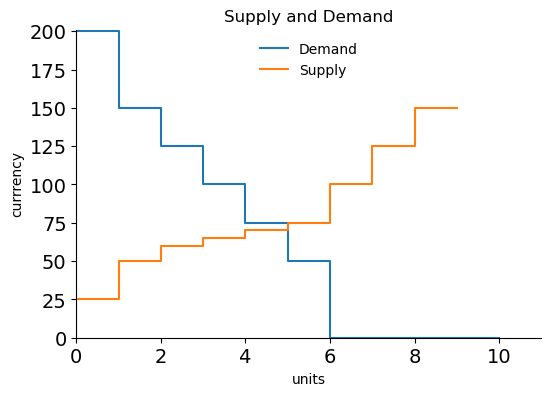


When orange market is in equilibrium we have:
equilibrium price    = 70 - 75
equilibrium quantity = 5
maximum surplus      = 380



In [29]:
buyer_1 = Buyer('B1', [200, 100, 50])
buyer_2 = Buyer('B2', [150, 125, 75])
seller_1 = Seller('S1', [50, 75, 125])
seller_2 = Seller('S2', [25, 65, 100])
seller_3 = Seller('S3', [60, 70, 150])
da = DoubleAuction('Orange Market')
env = MarketEnvironment("orange market")
env.add_buyer(buyer_1)
env.add_buyer(buyer_2)
env.add_seller(seller_1)
env.add_seller(seller_2)
env.add_seller(seller_3)
env.show_participants()
env.make_demand()
env.make_supply()
env.list_supply_demand()
env.plot_supply_demand()
env.calc_equilibrium()
env.show_equilibrium()

## Implement MarketSim Class


In [31]:
class MarketSim():
    """ run market Simulations """
    def __init__(self, sim_name, market_name):
        self.sim_name = sim_name
        self.market_name = market_name
        self.trader_list = []
        self.env = None

    def build_market(self):
        """eventually read from config file"""
        buyer_1 = Buyer('B1', [200, 100, 50])
        buyer_2 = Buyer('B2', [150, 125, 75])
        seller_1 = Seller('S1', [50, 75, 125])
        seller_2 = Seller('S2', [25, 65, 100])
        seller_3 = Seller('S3', [60, 70, 150])

        env = MarketEnvironment(self.market_name)
        env.reset(self.market_name)
        # build buyers and sellers
        env.add_buyer(buyer_1)
        env.add_buyer(buyer_2)
        env.add_seller(seller_1)
        env.add_seller(seller_2)
        env.add_seller(seller_3)

        # make supply and demand curves
        env.make_demand()
        env.make_supply()
        env.calc_equilibrium()
        self.env = env

    def show_market(self):
        env.show_participants()
        env.plot_supply_demand()
        env.show_equilibrium()

    def calc_efficiency(self, da, trader_list, max_surplus):
        """
        """
          
        buyer_surplus = 0
        seller_surplus = 0
        actual_surplus = 0
        efficiency = 0

        for trader in trader_list:
            trader_surplus = 0
            unit = 0
            if trader.name[0] == "B":
                res = trader.values.reservation_values
            else:
                res = trader.costs.unit_costs
            for contract in da.contracts:
                price, buyer_name, seller_name = contract
                if trader.name[0] == "B":
                    if trader.name == buyer_name:
                        surplus = res[unit] - price
                        unit = unit + 1
                        trader_surplus = trader_surplus + surplus
                        buyer_surplus = buyer_surplus + surplus
                else:
                    if trader.name == seller_name:
                        surplus = price - res[unit]
                        unit = unit + 1
                        trader_surplus = trader_surplus + surplus
                        seller_surplus = seller_surplus + surplus
                                
        actual_surplus = buyer_surplus + seller_surplus
        efficiency = (actual_surplus/max_surplus)*100.0
        return actual_surplus, efficiency
           

    def sim_period(self, num_rounds):
        da = DoubleAuction(self.market_name)

        # Register buyers and sellers
        for buyer in env.buyers:
            da.register(buyer)
        for seller in env.sellers:
            da.register(seller)

        # run simulation
        traders = []
        traders.extend(env.buyers)
        traders.extend(env.sellers)

        for round in range(0, num_rounds):
            trader = rnd.choice(traders)
            standing_bid = da.book.standing['bid']
            standing_ask = da.book.standing['ask']
            if trader.name[0] == "B": 
                bid = trader.bid(standing_bid)
                #print(f"standing bid = {standing_bid}, bid = {bid}")
                if bid != None: da.order(bid)
            if trader.name[0] == "S": 
                ask = trader.ask(standing_ask)
                #print(f"standing ask = {standing_ask}, ask = {ask}")
                if ask != None: da.order(ask)
        print()
        da.book.print_book()
        print()
        print("Contracts")
        for contract in da.contracts:
            print(contract)
        print()
        eq_units, eq_price_low, eq_price_high, max_surplus = env.get_equilibrium()
        actual_surplus, efficiency = self.calc_efficiency(da, traders, max_surplus)
        print(f"actual surplus = {actual_surplus}, efficiency = {efficiency}") 
              

Market Participants
-------------------
BUYERS
------
buyer B1 has values [200, 100, 50]
buyer B2 has values [150, 125, 75]
--------
SELLERS
-------
seller S1 has costs [50, 75, 125]
seller S2 has costs [25, 65, 100]
seller S3 has costs [60, 70, 150]



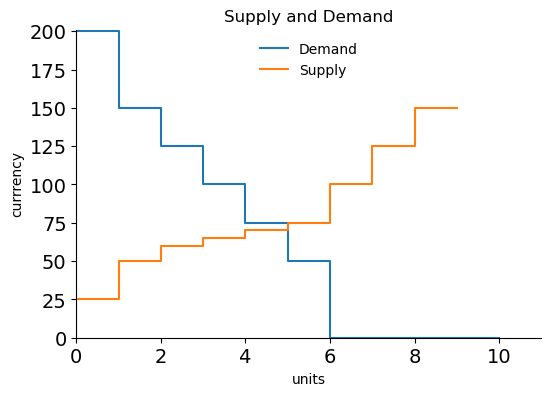


When orange market is in equilibrium we have:
equilibrium price    = 70 - 75
equilibrium quantity = 5
maximum surplus      = 380


 Order Book for Orange Market
1 start bid 0:Orange Market
2 start ask 999:Orange Market
3 standing ask 554:S2
4 standing ask 372:S2
5 standing ask 266:S2
6 standing bid 126:B1
7 standing ask 235:S3
8 standing bid 135:B1
9 standing bid 173:B1
10 standing bid 197:B1
11 standing bid 200:B1
12 contract ask 84:S2
13 start bid 0:Orange Market
14 start ask 999:Orange Market
15 standing bid 5:B2
16 standing bid 37:B1
17 standing ask 124:S3
18 standing ask 80:S2
19 standing bid 38:B1
20 standing ask 69:S3
21 standing ask 66:S2
22 standing ask 64:S3
23 rejected ask 64:S3
24 rejected ask 64:S3
25 standing ask 62:S3
26 contract bid 100:B2
27 start bid 0:Orange Market
28 start ask 999:Orange Market
29 standing bid 38:B2
30 standing ask 972:S1
31 standing bid 89:B1
32 standing ask 724:S2
33 standing ask 595:S2
34 standing ask 489:S3
35 standing bid 90:B1
36 standing ask

In [32]:
sim = MarketSim("sim_1", "Orange Market")
sim.build_market()
sim.show_market()
sim.sim_period(100)